In [2]:
import numpy as np 
import pandas as pd 
from datetime import datetime
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from mlxtend.regressor import StackingCVRegressor
from ngboost import NGBRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from math import sqrt
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

In [3]:
train = pd.read_csv('./train.csv')
print("Original train set size:", train.shape)
test = pd.read_csv('./test.csv')
print("Original test set size:", test.shape)

Original train set size: (1460, 81)
Original test set size: (1459, 80)


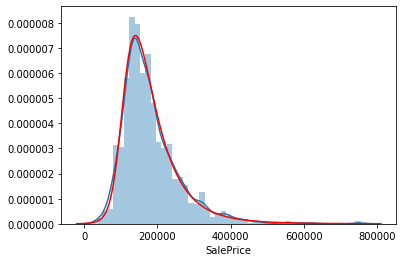

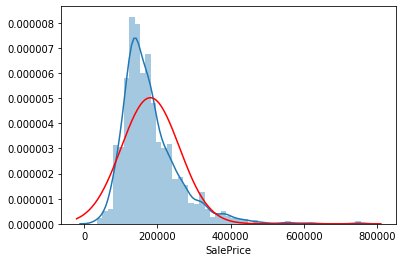

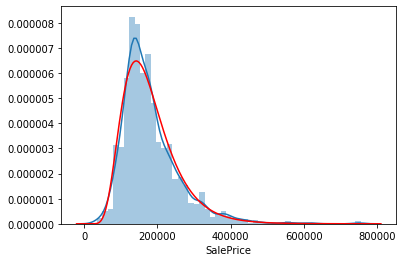

In [4]:
# SalePrice doesn't follow normal distribution

y = train['SalePrice']

# Johnson SU
plt.figure(1); 
sns.distplot(y, kde = True, fit = stats.johnsonsu, fit_kws = {'color':'r'})

# Normal
plt.figure(2);
sns.distplot(y, kde = True, fit = stats.norm, fit_kws = {'color':'r'})

# Log Normal
plt.figure(3);
sns.distplot(y, kde = True, fit = stats.lognorm, fit_kws = {'color':'r'})

In [5]:
# None of quantitative variables follow normal distribution

quantitative = [f for f in train.columns if train.dtypes[f] != 'object']
quantitative.remove('SalePrice')
quantitative.remove('Id')
qualitative = [f for f in train.columns if train.dtypes[f] == 'object']

test_normality = lambda x: stats.shapiro(x.fillna(0))[1] < 0.01
normal = pd.DataFrame(train[quantitative])
normal = normal.apply(test_normality)
print(not normal.any())

False


In [6]:
# Spearman correlation

def encode(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = frame[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()
    
    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, feature+'_E'] = o
    
qual_encoded = []

for q in qualitative:  
    encode(train, q)
    qual_encoded.append(q+'_E')

def spearman(frame, features):
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame['SalePrice'], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')
    
features = quantitative + qual_encoded

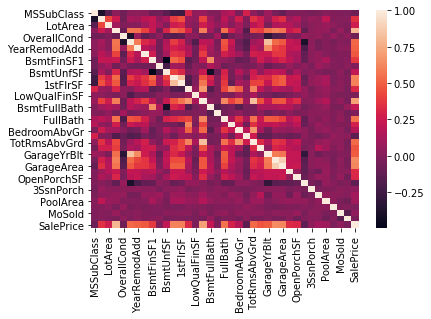

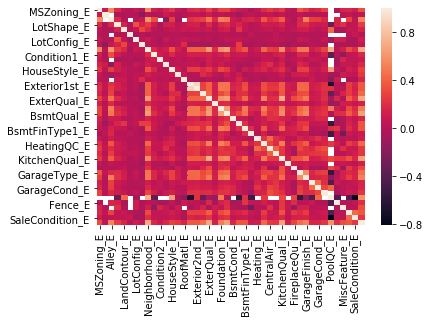

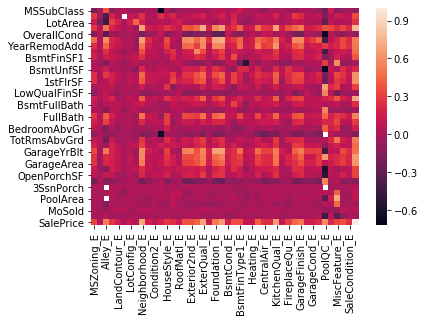

In [7]:
plt.figure(1)
corr = train[quantitative+['SalePrice']].corr()
sns.heatmap(corr)
plt.figure(2)
corr = train[qual_encoded+['SalePrice']].corr()
sns.heatmap(corr)
plt.figure(3)
corr = pd.DataFrame(np.zeros([len(quantitative)+1, len(qual_encoded)+1]), index=quantitative+['SalePrice'], columns=qual_encoded+['SalePrice'])
for q1 in quantitative+['SalePrice']:
    for q2 in qual_encoded+['SalePrice']:
        corr.loc[q1, q2] = train[q1].corr(train[q2])
sns.heatmap(corr)

In [8]:
train_ID = train['Id']
test_ID = test['Id']

# Drop the 'Id' colum since it's unnecessary for the prediction process
train.drop(['Id'], axis = 1, inplace = True)
test.drop(['Id'], axis = 1, inplace = True)

In [9]:
# Deleting outliers
train = train[train.GrLivArea < 4500]
train.reset_index(drop = True, inplace = True)

In [10]:
# Apply log transformation to all elements of the column
train["SalePrice"] = np.log1p(train["SalePrice"])
y = train.SalePrice.reset_index(drop=True)

In [11]:
# Process features

train_features = train.drop(['SalePrice'], axis = 1)
test_features = test

features = pd.concat([train_features, test_features]).reset_index(drop = True)
print(features.shape)

(2917, 122)


In [12]:
# Convert non-numeric predictors which are stored as numbers into strings

features['MSSubClass'] = features['MSSubClass'].apply(str)
features['YrSold'] = features['YrSold'].astype(str)
features['MoSold'] = features['MoSold'].astype(str)

In [13]:
# Fill in the missing values

features['Functional'] = features['Functional'].fillna('Typ')
features['Electrical'] = features['Electrical'].fillna("SBrkr")
features['KitchenQual'] = features['KitchenQual'].fillna("TA")
features["PoolQC"] = features["PoolQC"].fillna("None")
features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0])
features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])
features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])

for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    features[col] = features[col].fillna(0)
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    features[col] = features[col].fillna('None')
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    features[col] = features[col].fillna('None')

features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

objects = []
for i in features.columns:
    if features[i].dtype == object:
        objects.append(i)

features.update(features[objects].fillna('None'))

features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes:
        numerics.append(i)
features.update(features[numerics].fillna(0))

In [14]:
# Process features

numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics2 = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes:
        numerics2.append(i)
skew_features = features[numerics2].apply(lambda x: skew(x)).sort_values(ascending = False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

for i in skew_index:
    features[i] = boxcox1p(features[i], boxcox_normmax(features[i] + 1))

features = features.drop(['Utilities', 'Street', 'PoolQC'], axis = 1)

features['YrBltAndRemod'] = features['YearBuilt'] + features['YearRemodAdd']
features['TotalSF']=features['TotalBsmtSF'] + features['1stFlrSF'] + features['2ndFlrSF']
features['Total_sqr_footage'] = (features['BsmtFinSF1'] + features['BsmtFinSF2'] + features['1stFlrSF'] + features['2ndFlrSF'])
features['Total_Bathrooms'] = (features['FullBath'] + (0.5 * features['HalfBath']) + features['BsmtFullBath'] + (0.5 * features['BsmtHalfBath']))
features['Total_porch_sf'] = (features['OpenPorchSF'] + features['3SsnPorch'] + features['EnclosedPorch'] + features['ScreenPorch'] + features['WoodDeckSF'])

In [15]:
# Simplify features
features['haspool'] = features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
features['has2ndfloor'] = features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasgarage'] = features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
features['hasbsmt'] = features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasfireplace'] = features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [16]:
print(features.shape)
final_features = pd.get_dummies(features).reset_index(drop = True)
print(final_features.shape)

(2917, 129)
(2917, 376)


In [17]:
X = final_features.iloc[:len(y), :]
X_sub = final_features.iloc[len(X):, :]

In [18]:
print('X', X.shape, 'y', y.shape, 'X_sub', X_sub.shape)

X (1458, 376) y (1458,) X_sub (1459, 376)


In [19]:
# Delete outliers

outliers = [30, 88, 462, 631, 1322]
X = X.drop(X.index[outliers])
y = y.drop(y.index[outliers])

overfit = []
for i in X.columns:
    counts = X[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 > 99.94:
        overfit.append(i)

overfit = list(overfit)
#overfit.append('MSZoning_C (all)')

X = X.drop(overfit, axis = 1).copy()
X_sub = X_sub.drop(overfit, axis = 1).copy()

In [20]:
print('X:', X.shape, ', y:', y.shape, ', X_sub:', X_sub.shape)

X: (1453, 375) , y: (1453,) , X_sub: (1459, 375)


In [21]:
X['SalePrice'] = y
tr, te = train_test_split(X, test_size = 0.2)

y_tr = np.asarray(tr['SalePrice'])
tr = np.asarray(tr.drop(['SalePrice'], 1))
y_te =  np.asarray(te['SalePrice'])
te = np.asarray(te.drop(['SalePrice'], 1))

In [22]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [25]:
ngboost = NGBRegressor(natural_gradient = True, learning_rate = 0.01, 
                       n_estimators = 5000, minibatch_frac = 0.2, 
                       verbose = False)

begin_t = datetime.now()
ngboost.fit(tr, y_tr)
end_t = datetime.now()
y_pred = ngboost.predict(te)
score = rmsle(y_te, y_pred)
print("ngboost:", score)
print("time_cost:", end_t - begin_t)

ngboost: 0.10886683034246127
time_cost: 0:00:44.694416


In [26]:
xgboost = XGBRegressor(learning_rate = 0.01, n_estimators = 5000, 
                       objective='reg:squarederror', minibatch_frac = 0.2,
                       max_depth = 3)

begin_t = datetime.now()
xgboost.fit(tr, y_tr)
end_t = datetime.now()
y_pred = xgboost.predict(te)
score = rmsle(y_te, y_pred)
print("xgboost:", score)
print("time_cost:", end_t - begin_t)

xgboost: 0.11009908582486827
time_cost: 0:00:35.891280


In [28]:
lightgbm = LGBMRegressor(objective = 'regression', learning_rate = 0.01, 
                         n_estimators = 5000, verbose = -1, 
                         minibatch_frac = 0.2, num_leaves = 4,
                         max_bin = 20, bagging_freq = 5,
                         feature_fraction = 0.3, bagging_fraction = 0.6)

begin_t = datetime.now()
lightgbm.fit(tr, y_tr)
end_t = datetime.now()
y_pred = lightgbm.predict(te)
score = rmsle(y_te, y_pred)
print("lightgbm:", score)
print("time_cost:", end_t - begin_t)

lightgbm: 0.11111838028371576
time_cost: 0:00:01.584092


In [24]:
# Setup models    
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

ridge = make_pipeline(RobustScaler(), RidgeCV(alphas = alphas_alt))
begin_t = datetime.now()
ridge.fit(tr, y_tr)
end_t = datetime.now()
y_pred = ridge.predict(te)
score = rmsle(y_te, y_pred)
print("Kernel Ridge:", score)
print("time_cost:", end_t - begin_t)

lasso = make_pipeline(RobustScaler(), LassoCV(max_iter = 1e7, alphas = alphas2))
begin_t = datetime.now()
lasso.fit(tr, y_tr)
end_t = datetime.now()
y_pred = lasso.predict(te)
score = rmsle(y_te, y_pred)
print("Lasso:", score)
print("time_cost:", end_t - begin_t)

elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter = 1e7, alphas = e_alphas, l1_ratio = e_l1ratio))
begin_t = datetime.now()
elasticnet.fit(tr, y_tr)
end_t = datetime.now()
y_pred = elasticnet.predict(te)
score = rmsle(y_te, y_pred)
print("ElasticNet:", score)
print("time_cost:", end_t - begin_t)

svr = make_pipeline(RobustScaler(), SVR(C = 20, epsilon = 0.008, gamma = 0.0003))
begin_t = datetime.now()
svr.fit(tr, y_tr)
end_t = datetime.now()
y_pred = svr.predict(te)
score = rmsle(y_te, y_pred)
print("SVR:", score)
print("time_cost:", end_t - begin_t)

gbr = GradientBoostingRegressor(n_estimators = 5000, learning_rate = 0.01)
begin_t = datetime.now()
gbr.fit(tr, y_tr)
end_t = datetime.now()
y_pred = gbr.predict(te)
score = rmsle(y_te, y_pred)
print("GradientBoosting:", score)
print("time_cost:", end_t - begin_t)

Kernel Ridge: 0.10097964698478858
time_cost: 0:00:00.243000
Lasso: 0.10005869637112508
time_cost: 0:00:00.777903
ElasticNet: 0.10050281767669685
time_cost: 0:00:02.216490
SVR: 0.10216852774962584
time_cost: 0:00:00.799843
GradientBoosting: 0.1118440852267898
time_cost: 0:00:37.974439


In [33]:
y_te

array([12.32386013, 11.45900768, 11.71994776, 11.88449592, 12.0435596 ,
       12.09514667, 11.3621142 , 11.81303746, 11.77529742, 11.95118685,
       12.35233947, 12.45683525, 11.91773036, 12.3327097 , 11.60824474,
       12.00457439, 11.58989577, 11.90834697, 11.69525536, 12.08673152,
       12.14950759, 12.92999391, 12.50618094, 12.01067193, 11.66135409,
       11.68688718, 11.76757544, 11.56077233, 12.31043717, 12.50618094,
       11.81303746, 11.28854365, 11.82701332, 12.17819258, 12.25486757,
       11.88449592, 11.80932691, 12.99453228, 11.87583792, 11.74404512,
       12.01370681, 11.95118685, 12.17819258, 11.94146236, 11.59451467,
       12.16525586, 11.00211651, 12.08954445, 12.67000161, 11.81303746,
       11.66993776, 11.47730865, 12.07540002, 11.84223641, 12.73596828,
       12.81392062, 11.74006901, 12.36308067, 11.9826228 , 12.08108182,
       12.04061411, 11.84940484, 11.74404512, 11.80932691, 12.35978466,
       12.38422302, 11.56172515, 11.60824474, 11.97666577, 12.36